In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from compress_pickle import dump, load
from math import log
from scipy.stats import kstest
path = './files/'

def open_pickle(file):
    with open(path+file, 'rb') as pickle_file:
        return load(path=pickle_file, compression='infer')

THINGS TO LOOK INTO:
- Some gene sets have 0 genes - not mapped?
- Some gene sets have the same genes - probably also a result of mapping, should I make them into one?=

In [2]:
# import clustering results
# /clustering_results/leiden_2_15_0001_05_msigdb_c2_cgp.gz
# /clustering_results/leiden_2_15_0001_05_msigdb_c3_cgp.gz
# /clustering_results/leiden_2_15_0001_05_msigdb_c6_cgp.gz

# msigdb_c2_cgp_clust = open_pickle('clustering_results/leiden_2_15_0001_05_msigdb_c2_cgp.gz')
msigdb_c3_tft_clust = open_pickle('clustering_results/leiden_2_15_0001_05_msigdb_c3_tft.gz')
# msigdb_c6_all_clust = open_pickle('clustering_results/leiden_2_15_0001_05_msigdb_c6_all.gz')

In [80]:
threshold = 0.05

def get_cluster_distributions(clust_df, filt=False):
    distributions = pd.DataFrame()
    for (res, betas) in clust_df.items():
        for (beta, cluster_enrichments) in betas.items():
            if filt:
                cluster_sizes = [float(log(cluster[1], 10)) for cluster in cluster_enrichments[0].values() if ((cluster[0]['FDR'] < threshold).any())]
            else:
                cluster_sizes = [float(log(cluster[1], 10)) for cluster in cluster_enrichments[0].values() if cluster[1] > 1]
                
            n_clusters = len(cluster_sizes)
            distributions = pd.concat([distributions, pd.DataFrame({'size': cluster_sizes, 'resolution':[res]*n_clusters, 'beta': [beta]*n_clusters})])
    return distributions

to_get = msigdb_c2_cgp_clust
distributions_df = get_cluster_distributions(to_get, filt=False)
distributions_df_filt = get_cluster_distributions(to_get, filt=True)

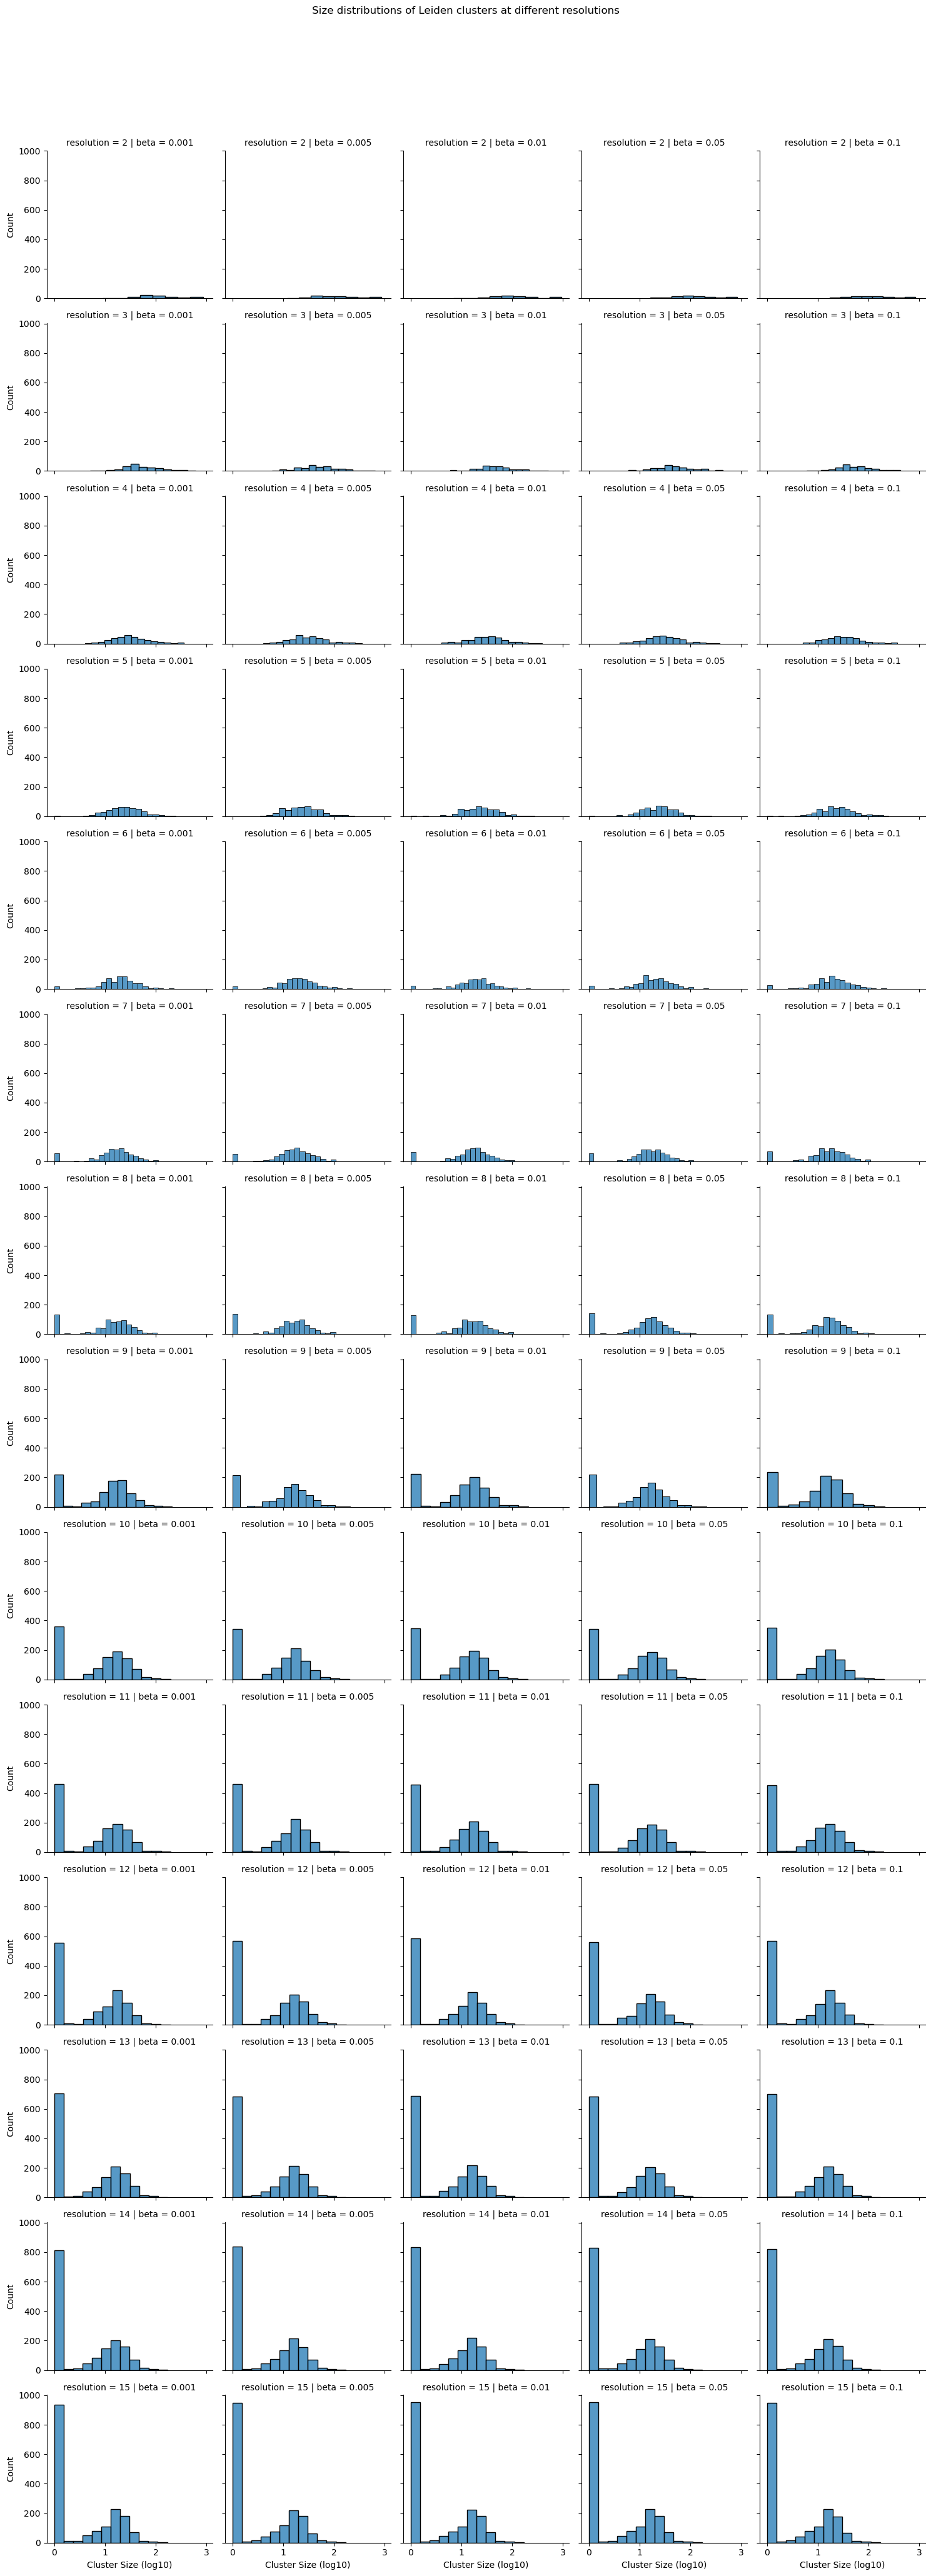

In [55]:
fig1 = sns.FacetGrid(distributions_df, row='resolution',col='beta')
fig1.map(sns.histplot, 'size')
fig1.figure.suptitle("Size distributions of Leiden clusters at different resolutions")
fig1.figure.subplots_adjust(top=0.925)
fig1.set_xlabels('Cluster Size (log10)')
for ax in fig1.axes.flat:
    ax.text(0.85, 0.85, ax)

# fig2 = sns.FacetGrid(distributions_df_filt, row='resolution',col='beta')
# fig2.map(sns.histplot, 'size')
# fig2.figure.suptitle("Size distributions of Leiden clusters at different resolutions")
# fig2.figure.subplots_adjust(top=0.925)
# fig2.set_xlabels('Cluster Size (log10)')

#fig.savefig('./images/grid_leiden_2_5_001_05_msigdbcgp.png')

In [ ]:
from scipy.stats import kstest

base = msigdb
base_distribution = [log(len(gene_set), 10) for gene_set in base.values() if len(gene_set) != 0] 
ks_test_results_df = pd.DataFrame()
distribution = distributions_df
for res in distribution['resolution'].unique():
    for beta in distribution['beta'].unique():
        sizes = distribution[((distribution['resolution'] == res) & (distribution['beta'] == beta))]['size']
        test_p = kstest(sizes, base_distribution).pvalue
        ks_test_results_df = pd.concat([ks_test_results_df, pd.DataFrame({'resolution': [res], 'beta': [beta], 'p_value': [test_p]})])

print(ks_test_results_df[ks_test_results_df['pvalue'] > 0.05])

Empty DataFrame
Columns: [resolution, beta, p_value]
Index: []


435.99999999999983
1.0


Text(0.5, 23.52222222222222, 'Cluster Size (log10)')

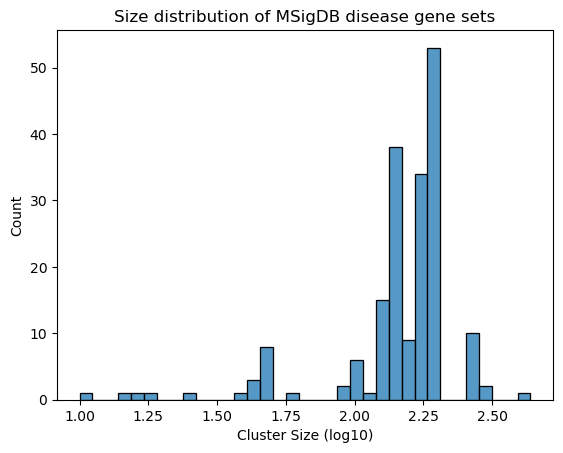

In [ ]:
set_sizes = [log(len(gene_set), 10) for gene_set in msigdb_c6_dict.values() if len(gene_set) != 0] 
fig = sns.histplot(set_sizes)
fig.set_title("Size distribution of MSigDB disease gene sets")
fig.get_figure().savefig("helloo.png")
fig.set_xlabel("Cluster Size (log10)")

In [26]:

threshold = 0.01

def calculate_CCS(enrichment_dict, threshold=0.05):
    CCS_df = pd.DataFrame()
    for (res, betas) in enrichment_dict.items():
        for (beta, cluster_enrichments) in betas.items():
            enriched = list()
            for cluster in cluster_enrichments[0].values():
                cluster=cluster[0]
                enriched_paths = cluster[cluster['FDR'] < threshold]
                if enriched_paths.empty:
                    continue
                enriched.append(enriched_paths[:][['pathway_id', 'FDR']])


            # enriched = [cluster[0][cluster[0]['FDR'] < threshold] for cluster in cluster_enrichments[0].values()]
            n_enriched_clusters = len(enriched)
            if n_enriched_clusters == 0:
                CCS_df = pd.concat([CCS_df, pd.DataFrame({'resolution': [res], 'beta': [beta], 'CCS': [0]})])
                continue
            enriched_df = pd.concat(enriched)
            avg_set_per_cluster = len(enriched_df) / n_enriched_clusters
            avg_cluster_per_set = enriched_df.groupby('pathway_id')['pathway_id'].count().mean()
            CCS = avg_set_per_cluster / avg_cluster_per_set
            CCS_df = pd.concat([CCS_df, pd.DataFrame({'resolution': [res],
                                                      'beta': [beta],
                                                      'n_clusters': len(cluster_enrichments[0]),
                                                      'n_enriched': n_enriched_clusters ,
                                                      'avg_s/c': avg_set_per_cluster,
                                                      'avg_c/s':avg_cluster_per_set,
                                                      'CCS': [CCS]})])
    return CCS_df
            

CCSs = calculate_CCS(msigdb_c3_tft_clust)

In [71]:
CCSs['Error'] = CCSs['avg_s/c'] + CCSs['avg_c/s'] - 2

CCSs.sort_values('resolution')


,resolution,beta,n_clusters,n_enriched,avg_s/c,avg_c/s,CCS,Error
0,2,0.005,75,33,25.818182,1.557587,16.575758,25.375769
0,2,0.001,77,38,20.763158,1.777027,11.684211,20.540185
0,2,0.010,79,36,22.027778,1.548828,14.222222,21.576606
0,2,0.100,79,36,24.444444,1.641791,14.888889,24.086235
0,2,0.050,83,33,22.575758,1.662946,13.575758,22.238704
...,...,...,...,...,...,...,...,...
0,15,0.001,1707,50,3.440000,1.246377,2.760000,2.686377
0,15,0.005,1702,50,3.480000,1.270073,2.740000,2.750073
0,15,0.010,1711,55,3.381818,1.300699,2.600000,2.682517
0,15,0.050,1711,52,3.403846,1.264286,2.692308,2.668132


684


<Axes: ylabel='Count'>

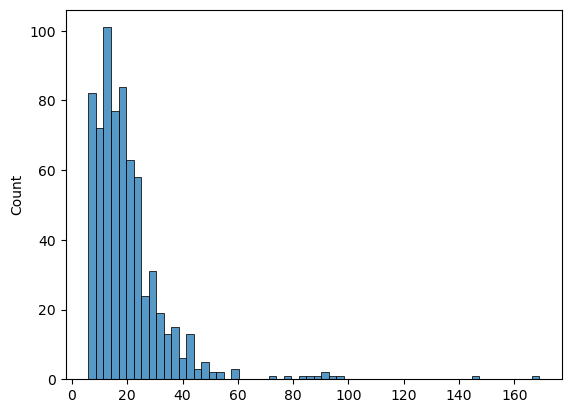

In [68]:
sizes = [len(cluster[2]) for cluster in msigdb_c3_tft_clust[15][0.01][0].values()]
print(len([size for size in sizes if size > 5]))
sns.histplot([size for size in sizes if size > 5])

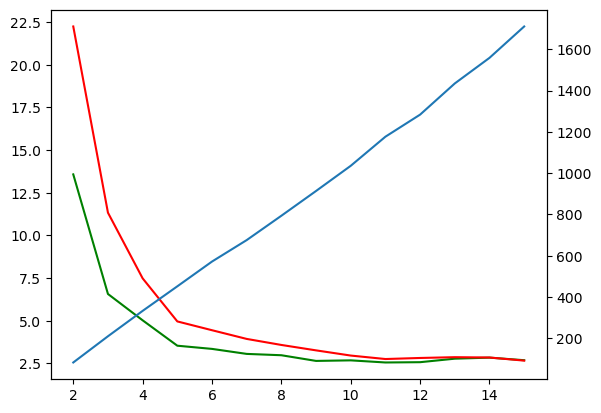

In [107]:
fig, ax = plt.subplots(1,1)

beta = 0.05

beta_01_CCS = {row[1]['resolution'] : row[1]['CCS'] for row in CCSs.iterrows() if row[1]['beta'] == beta}
beta_01_n = {row[1]['resolution'] : row[1]['n_clusters'] for row in CCSs.iterrows() if row[1]['beta'] == beta}
beta_01_error = {row[1]['resolution'] : row[1]['Error'] for row in CCSs.iterrows() if row[1]['beta'] == beta}

ax.plot(beta_01_CCS.keys(), beta_01_CCS.values(), c='g')
ax.plot(beta_01_error.keys(), beta_01_error.values(), c='r')
ax2 = ax.twinx()
ax2.plot(beta_01_CCS.keys(), beta_01_n.values())


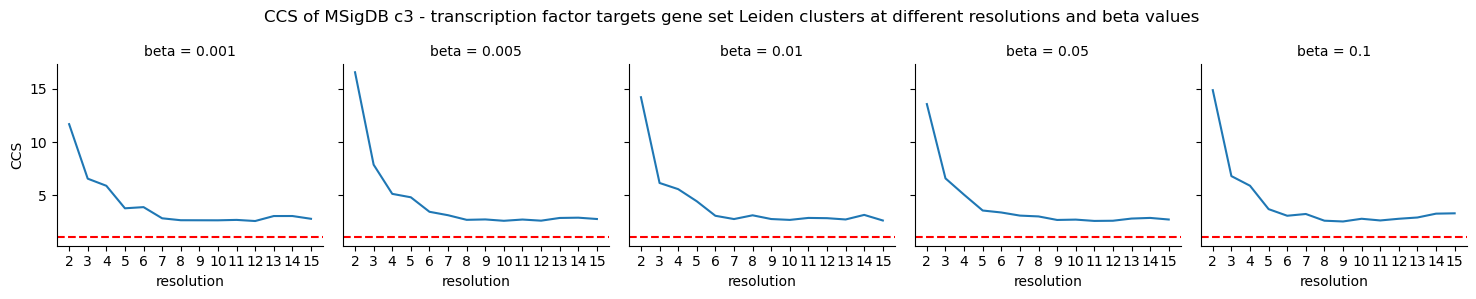

In [74]:
fig = sns.FacetGrid(CCSs, col='beta')
fig.map(sns.lineplot, 'resolution', 'CCS')
fig.set(xticks=CCSs['resolution'].unique())
# fig.set(ybound=[0,3])
fig.refline(y=1, color='red')
fig.fig.subplots_adjust(top=0.8)
fig.fig.suptitle("CCS of MSigDB c3 - transcription factor targets gene set Leiden clusters at different resolutions and beta values")

fig.savefig('img.png')

In [4]:
# msigdb_c2_cgp_dict = open_pickle('msigdb_c2_cgp_dict.pkl')
msigdb_c3_tft_dict = open_pickle('msigdb_c3_tft_dict.pkl')

In [5]:
gene_sets = pd.Series([len(set(gene_set)) for gene_set in msigdb_c3_tft_dict.values()])

gene_sets.where(gene_sets == 0).dropna()

82     0.0
152    0.0
282    0.0
dtype: float64

In [6]:
# 
from itertools import combinations

gene_sets = pd.Series([set(gene_set) for gene_set in msigdb_c3_tft_dict.values()])  # some gene sets have no mapping aka have 0 genes
overlap_coefficients = list()

for i in range(len(gene_sets)-1):
    for j in range(i+1, len(gene_sets)):
        set_A = gene_sets[i]
        set_B = gene_sets[j]
        # if set_A == set_B:
        #     print(i)
        #     print(j)
        if len(set_A) == 0 or len(set_B) == 0: # tft 3 sets with 0
            continue
        ov_coeff = (len(set_A.intersection(set_B)))/(min(len(set_A), len(set_B)))
        overlap_coefficients.append(ov_coeff)

jaccard = list()
for set_A, set_B in combinations(gene_sets, 2):
    if len(set_A) == 0 or len(set_B) == 0: # tft 3 sets with 0
        continue
    jacc = len(set_A.intersection(set_B))/len(set_A.union(set_B))
    jaccard.append(jacc)
len(jaccard) == len(overlap_coefficients)

True

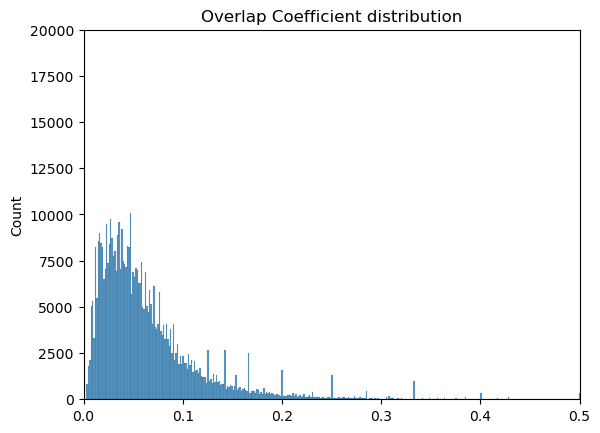

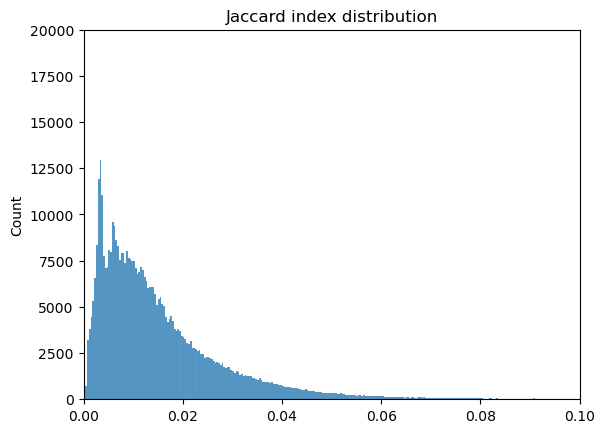

In [76]:

fig1 = sns.histplot(overlap_coefficients)
fig1.set_ylim([0, 20000])
fig1.set_xlim([0, 0.5])
fig1.set_title("Overlap Coefficient distribution")


# fig2 = sns.histplot(jaccard)
# fig2.set_title("Jaccard index distribution")
# fig2.set_ylim([0, 20000])
# fig2.set_xlim([0, 0.1])
# plt.show()

18126
821
15.0


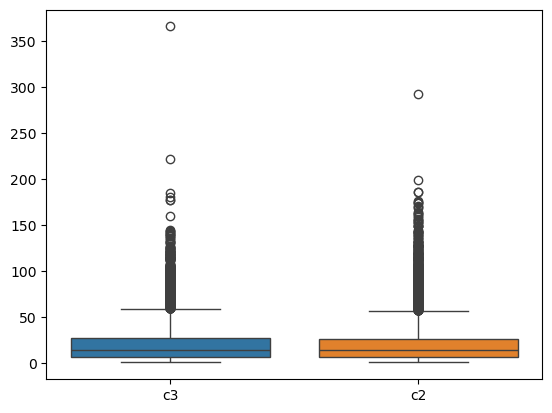

In [32]:
# investigate dataset overlap - number of times that each gene appears in all gene sets
import matplotlib.pyplot as plt


genes = pd.Series([str(gene) for gene_set in msigdb_c3_tft_dict.values() for gene in gene_set])
gene_freqs = genes.value_counts(normalize=False)
genes = pd.Series([str(gene) for gene_set in msigdb_c2_cgp_dict.values() for gene in gene_set])
gene_freqs2 = genes.value_counts(normalize=False)



fig = sns.boxplot(pd.DataFrame({'c3': gene_freqs, 'c2': gene_freqs2}))

upper_c3 = gene_freqs.mean() + 2*gene_freqs.std()
print(len(gene_freqs))
print(len(gene_freqs.where(gene_freqs > upper_c3).dropna()))
print(gene_freqs.median())